# Recommendation Systems Exhibition

In [1]:
# Import packages used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from data import import_data 
from methods import (utils, losses, matrix_factorization, AutoRec,   
    neural_collaborative_filtering)

## Datasets

### Movielens Data

In [2]:
# Import data
names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_csv("data/u.data", delimiter='\t', names = names, engine = "python")
num_users = data.user_id.unique().shape[0]
num_items = data.item_id.unique().shape[0]

## Explicit Models (with MovieLens)

### Matrix Factorization

In [ ]:
# Obtain the data
num_users, num_items, train_iter, test_iter = import_data.split_and_load_ml100k(data,
    num_users, num_items, test_ratio = 0.1, batch_size=512)

In [ ]:
# Define evaluator
def evaluator(net, test_iter):
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        r_hat = net(users, items)
        rmse_value = torch.sqrt(((r_hat - ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [ ]:
# Prepare model
lr, num_epochs, wd = 0.002, 20, 1e-5

mf_net = matrix_factorization.MF(30, num_users, num_items)
optimizer = optim.Adam(mf_net.parameters(), lr = lr, weight_decay = wd)

In [ ]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    mf_net.train()
    for i, (users, items, ratings) in enumerate(train_iter):
        optimizer.zero_grad()

        predictions = mf_net(users, items)
        output = ((predictions - ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += users.shape[0]
    
    # Evaluate
    mf_net.eval()
    rmse = evaluator(mf_net, test_iter)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

In [ ]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"Matrix Factorization Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

### AutoRec

In [ ]:
# Obtain the data
train_data, test_data = import_data.split_data_ml100k(data, num_users, num_items)

_, _, _, train_inter_matrix = import_data.load_data_ml100k(train_data, num_users, num_items)
_, _, _, test_inter_matrix = import_data.load_data_ml100k(test_data, num_users, num_items)

train_inter_tensor = torch.from_numpy(train_inter_matrix).to(torch.float)
test_inter_tensor = torch.from_numpy(test_inter_matrix).to(torch.float)

train_iter = DataLoader(train_inter_tensor, shuffle = True, batch_size = 256,
    num_workers = 4)
test_iter = DataLoader(test_inter_tensor, shuffle = False, batch_size = 1024,
    num_workers = 4)

In [ ]:
# Define evaluator
def evaluator(network, test_iter):
    rmse_list = []
    for idx, users_ratings in enumerate(test_iter):
        recons = network(users_ratings)
        rmse_value = torch.sqrt(
            ((torch.sign(users_ratings) * recons - users_ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [ ]:
# Prepare model
lr, num_epochs, wd = 0.002, 25, 1e-5

autorec_net = AutoRec(500, num_users)
optimizer = optim.Adam(autorec_net.parameters(), lr = lr, weight_decay=wd)

In [ ]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    autorec_net.train()
    for i, user_ratings in enumerate(train_iter):
        optimizer.zero_grad()

        predictions = autorec_net(user_ratings)
        output = ((predictions - user_ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += user_ratings.shape[0]
    
    # Evaluate
    autorec_net.eval()
    rmse = evaluator(autorec_net, test_iter)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

In [ ]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"AutoRec Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

## Implicit Models (with MovieLens)

In [4]:
# Define metrics
def hit_and_auc(rankedlist, test_item, k):
    test_item = int(test_item)
    hits_k = test_item in rankedlist[:k]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist) if int(val) == test_item]

    max_num = len(rankedlist) - 1
    auc = 1.0 * (max_num - hits_all[0][0]) / \
        max_num if len(hits_all) > 0 else 0
    return hits_k, auc

## NeuMF

In [5]:
# Prepare Dataset
batch_size = 1024
train_data, test_data = import_data.split_data_ml100k(data, num_users,
    num_items,'seq-aware')

# Training data
users_train, items_train, _, interactions = import_data.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
train_dataset = neural_collaborative_filtering.PRDataset(users_train, items_train, 
    interactions, num_items)
train_iter = DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
    num_workers = 4)

# Test data
_, _, _, test_interactions = import_data.load_data_ml100k(test_data, num_users, num_items,
    feedback="implicit")

In [6]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, interactions, num_users, num_items):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = TensorDataset(torch.from_numpy(np.array(user_ids)),    
            torch.from_numpy(np.array(item_ids)))
        test_data_iter = DataLoader(test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs) in enumerate(test_data_iter):
            scores.extend(list(net(user_idxs, item_idxs).detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        
        temp = hit_and_auc(ranked_items[u], test_input[u][0], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [7]:
# Define weight initializer
def weights_init(module):
    if isinstance(module, nn.Embedding) or isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=0.01)

In [8]:
# Create and initialize model
lr, num_epochs, wd = 0.01, 10, 1e-5

neuMF_net = neural_collaborative_filtering.NeuMF(10, num_users, num_items,
    nums_hiddens=[10, 10, 10])
neuMF_net.apply(weights_init)
loss = losses.BPR_Loss
optimizer = optim.Adam(neuMF_net.parameters(), lr = lr, weight_decay=wd)

In [9]:
# Train and evaluate the model
hit_rate_list = []
auc_list = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    neuMF_net.train()
    for i, (user_idxs, item_idxs, neg_items) in enumerate(train_iter):
        optimizer.zero_grad()

        p_pos = neuMF_net(user_idxs, item_idxs)
        p_neg = neuMF_net(user_idxs, neg_items)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    neuMF_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(neuMF_net, test_interactions, interactions, 
        num_users, num_items)
    hit_rate_list.append(hit_rate)
    auc_list.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.5614053469776634
	hit_rate = 0.19300106044538706
	auc = 0.7862909011736797
Epoch 1:
	loss = 0.4959854364277204
	hit_rate = 0.23223753976670203
	auc = 0.7921716071575523
Epoch 2:
	loss = 0.471557453904578
	hit_rate = 0.22693531283138918
	auc = 0.8306410865872321
Epoch 3:
	loss = 0.44809966738788176
	hit_rate = 0.23223753976670203
	auc = 0.8396591206114082
Epoch 4:
	loss = 0.4383479408453553
	hit_rate = 0.2449628844114528
	auc = 0.8473335169242069
Epoch 5:
	loss = 0.43216053384391373
	hit_rate = 0.256627783669141
	auc = 0.8526946503887074
Epoch 6:
	loss = 0.4268267798173692
	hit_rate = 0.2651113467656416
	auc = 0.855639232832444
Epoch 7:
	loss = 0.4236004029349303
	hit_rate = 0.271474019088017
	auc = 0.8551323009669622
Epoch 8:
	loss = 0.42134476828652395
	hit_rate = 0.2576882290562036
	auc = 0.8555876452955083
Epoch 9:
	loss = 0.418186463438112
	hit_rate = 0.27783669141039236
	auc = 0.8548062718164149


(0.0, 1.0)

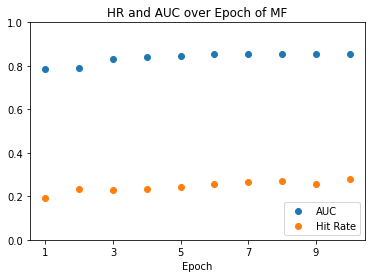

In [12]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list, label = "AUC")
plt.scatter(x, hit_rate_list, label = "Hit Rate")
plt.title("HR and AUC over Epoch of MF")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

## Caser

In [ ]:
# Load dataset
TARGET_NUM, L, batch_size = 1, 5, 4096
train_data, test_data = split_data_ml100k(data, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=get_dataloader_workers())
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

In [ ]:
devices = try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.04, 8, 1e-5, 'adam'
loss = BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

hit_rate_list_caser, auc_list_caser = train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter, num_users, num_items, num_epochs, devices, evaluate_ranking, candidates, eval_step=1)